Dense layer BI-LSTM with attention layer

In [ ]:
import tensorflow as tf

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, encoder_output):
        score = self.V(tf.nn.tanh(self.W(encoder_output)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

def create_model(input_shape, lstm_units, dense_units):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True))(inputs)
    context_vector, attention_weights = AttentionLayer(dense_units)(x)
    outputs = tf.keras.layers.Dense(1, activation='linear')(context_vector)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (None, 9) 
lstm_units = 64
dense_units = 64

model = create_model(input_shape, lstm_units, dense_units)
model.summary()

: 

In [45]:
import pandas as pd
import numpy as np

In [46]:
dailyEnergy = pd.read_excel('dailyEnergyWithFeatures.xlsx')
dailyEnergy['weekday'] = dailyEnergy['TimeReviewed'].dt.dayofweek
dailyEnergy['day_type'] = np.zeros(len(dailyEnergy))
dailyEnergy['day_type'][(dailyEnergy['weekday']==5)|(dailyEnergy['weekday']==6)|(dailyEnergy['TimeReviewed']=='2017-12-26')|(dailyEnergy['TimeReviewed']=='2018-1-1')|(dailyEnergy['TimeReviewed']=='2018-1-14')|(dailyEnergy['TimeReviewed']=='2018-1-26')|(dailyEnergy['TimeReviewed']=='2018-5-1')|(dailyEnergy['TimeReviewed']=='2018-8-15')|(dailyEnergy['TimeReviewed']=='2018-10-2')|(dailyEnergy['TimeReviewed']=='2018-12-25')|(dailyEnergy['TimeReviewed']=='2019-1-1')|(dailyEnergy['TimeReviewed']=='2019-1-14')|(dailyEnergy['TimeReviewed']=='2019-1-26')|(dailyEnergy['TimeReviewed']=='2019-5-1')]=1
dailyEnergy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   TimeReviewed                 505 non-null    datetime64[ns]
 1   Solar_Power_Consumption(Kw)  505 non-null    float64       
 2   Temp( C)                     505 non-null    float64       
 3   EmployeeCount                505 non-null    int64         
 4   weekday                      505 non-null    int32         
 5   day_type                     505 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int32(1), int64(1)
memory usage: 21.8 KB


C:\Users\atuli\AppData\Local\Temp\ipykernel_18040\3723895554.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dailyEnergy['day_type'][(dailyEnergy['weekday']==5)|(dailyEnergy['weekday']==6)|(dailyEnergy['TimeReviewed']=='2017-12-26')|(dai

In [47]:
df_elect = dailyEnergy[["Temp( C)", "EmployeeCount", "weekday","day_type", 'Solar_Power_Consumption(Kw)']]

elect_train = pd.DataFrame(data=df_elect.head(350))
elect_test = pd.DataFrame(data=df_elect.head(155))

XX_elect_train = elect_train.drop('Solar_Power_Consumption(Kw)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = elect_test.drop('Solar_Power_Consumption(Kw)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = elect_train[['Solar_Power_Consumption(Kw)']]
YY_elect_test = elect_test[['Solar_Power_Consumption(Kw)']]

In [48]:
df_elect = dailyEnergy[["Temp( C)", "EmployeeCount", "weekday","day_type", 'Solar_Power_Consumption(Kw)']]

elect_train = pd.DataFrame(data=df_elect.head(350))
elect_test = pd.DataFrame(data=df_elect.head(155))

XX_elect_train = elect_train.drop('Solar_Power_Consumption(Kw)', axis = 1).reset_index().drop('index', axis = 1)
XX_elect_test = elect_test.drop('Solar_Power_Consumption(Kw)', axis = 1).reset_index().drop('index', axis = 1)

YY_elect_train = elect_train[['Solar_Power_Consumption(Kw)']]
YY_elect_test = elect_test[['Solar_Power_Consumption(Kw)']]

In [49]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [50]:
from sklearn.preprocessing import LabelEncoder

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_excel('energy.xlsx', header=0, index_col=0)
values = dataset[['Solar_Power_Consumption(Kw)','Temp( C)','EmployeeCount','weekday','day_type']].values
len(values)
#values = values.reshape((len(values), 7))
# ensure all data is float
#values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#drop the values you dont want to predict
#reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
print(reframed.head())

reframed

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)  \
1   0.714262   0.062762   0.521552   0.166667        1.0  0.775761  0.112971   
2   0.775761   0.112971   0.000000   0.333333        0.0  0.769228  0.040446   
3   0.769228   0.040446   0.000000   0.500000        0.0  0.721061  0.040446   
4   0.721061   0.040446   0.000000   0.666667        0.0  0.446244  0.184100   
5   0.446244   0.184100   0.000000   0.833333        1.0  0.000000  0.108787   

   var3(t)   var4(t)  var5(t)  
1    0.000  0.333333      0.0  
2    0.000  0.500000      0.0  
3    0.000  0.666667      0.0  
4    0.000  0.833333      1.0  
5    0.125  1.000000      1.0  


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.714262,0.062762,0.521552,0.166667,1.0,0.775761,0.112971,0.000000,0.333333,0.0
2,0.775761,0.112971,0.000000,0.333333,0.0,0.769228,0.040446,0.000000,0.500000,0.0
3,0.769228,0.040446,0.000000,0.500000,0.0,0.721061,0.040446,0.000000,0.666667,0.0
4,0.721061,0.040446,0.000000,0.666667,0.0,0.446244,0.184100,0.000000,0.833333,1.0
5,0.446244,0.184100,0.000000,0.833333,1.0,0.000000,0.108787,0.125000,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
500,0.739638,0.304045,0.818966,0.500000,0.0,0.872778,0.336123,0.793103,0.666667,0.0
501,0.872778,0.336123,0.793103,0.666667,0.0,0.512937,0.285412,0.715517,0.833333,1.0
502,0.512937,0.285412,0.715517,0.833333,1.0,0.000000,0.598326,0.047414,1.000000,1.0
503,0.000000,0.598326,0.047414,1.000000,1.0,0.692707,0.353237,0.801724,0.000000,0.0


In [51]:
values = reframed.values

n_train_time = 365 # training size is taken for 1 year (2017/26/12 to 2018/26/12)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [52]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [53]:
train_X.shape

(365, 1, 9)

In [56]:
history = model.fit(train_X, train_y, epochs=50, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50


6/6 - 0s - 18ms/step - accuracy: 0.9726 - loss: 0.0576 - val_accuracy: 0.9784 - val_loss: 0.0622
Epoch 2/50
6/6 - 0s - 17ms/step - accuracy: 0.9726 - loss: 0.0574 - val_accuracy: 0.9784 - val_loss: 0.0620
Epoch 3/50
6/6 - 0s - 15ms/step - accuracy: 0.9726 - loss: 0.0572 - val_accuracy: 0.9784 - val_loss: 0.0618
Epoch 4/50
6/6 - 0s - 12ms/step - accuracy: 0.9726 - loss: 0.0570 - val_accuracy: 0.9784 - val_loss: 0.0617
Epoch 5/50
6/6 - 0s - 15ms/step - accuracy: 0.9753 - loss: 0.0569 - val_accuracy: 0.9784 - val_loss: 0.0615
Epoch 6/50
6/6 - 0s - 16ms/step - accuracy: 0.9753 - loss: 0.0567 - val_accuracy: 0.9784 - val_loss: 0.0614
Epoch 7/50
6/6 - 0s - 13ms/step - accuracy: 0.9753 - loss: 0.0565 - val_accuracy: 0.9784 - val_loss: 0.0612
Epoch 8/50
6/6 - 0s - 11ms/step - accuracy: 0.9753 - loss: 0.0564 - val_accuracy: 0.9784 - val_loss: 0.0611
Epoch 9/50
6/6 - 0s - 11ms/step - accuracy: 0.9753 - loss: 0.0562 - val_accuracy: 0.9784 - val_loss: 0.0610
Epoch 10/50
6/6 - 0s - 11ms/step - accu

In [55]:
score = model.evaluate(test_X, test_y, batch_size=70, verbose=1)

print('Test accuracy:', score[1])
print('Accuracy:',score[1]*100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9761 - loss: 0.0628 
Test accuracy: 0.9784172773361206
Accuracy: 97.84172773361206


In [ ]:
import matplotlib.pyplot as plt

: 

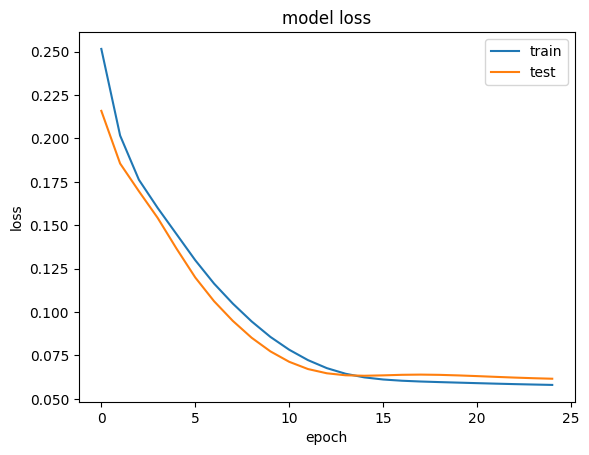

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [34]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],9))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
Test RMSE: 4441.182


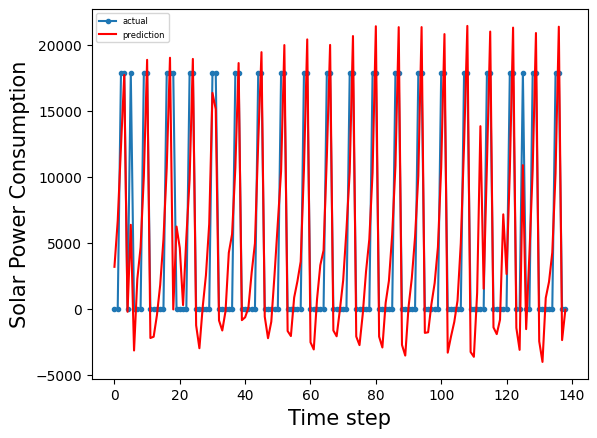

In [35]:
aa=[x for x in range(139)]
plt.plot(aa, inv_y[:139], marker='.', label="actual")
plt.plot(aa, inv_yhat[:139], 'r', label="prediction")
plt.ylabel('Solar Power Consumption', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=6)
plt.show()

In [37]:
n = 80
change=100*abs(inv_yhat[n]-inv_y[n])/inv_yhat[n]
print("The value of the consumption the next day will be",inv_yhat[n],"and the percentage change is ",change,"%")

The value of the consumption the next day will be 21413.937863171665 and the percentage change is  16.428341650209415 %
